### Setup

In [1]:

import os, sys
HOME = os.environ['HOME']  # change if necessary
sys.path.append(f'{HOME}/Finite-groups/src')

In [2]:
import torch as t
import numpy as np
from matplotlib import pyplot as plt
import json
from itertools import product
from jaxtyping import Float
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import plotly.graph_objects as go
import copy
import math
from itertools import product
import pandas as pd
from typing import Union
from einops import repeat
from huggingface_hub import snapshot_download
from huggingface_hub.utils import disable_progress_bars


from model import MLP3, MLP4, InstancedModule
from utils import *
from group_data import *
from model_utils import *
from group_utils import *
from llc import *
%load_ext autoreload
%autoreload 2

Syntax warning: Unbound global variable in /usr/share/gap/pkg/browse/PackageIn\
fo.g:73
  if not IsKernelExtensionAvailable("Browse", "ncurses") then
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
Syntax warning: Unbound global variable in /usr/share/gap/pkg/cddinterface/Pac\
kageInfo.g:85
    if not IsKernelExtensionAvailable("CddInterface") then
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
Syntax warning: Unbound global variable in /usr/share/gap/pkg/crypting/Package\
Info.g:82
   if not IsKernelExtensionAvailable("crypting") then
          ^^^^^^^^^^^^^^^^^^^^^^^^^^
Syntax warning: Unbound global variable in /usr/share/gap/pkg/curlinterface/Pa\
ckageInfo.g:114
  if not IsKernelExtensionAvailable("curlinterface", "curl") then
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
Syntax warning: Unbound global variable in /usr/share/gap/pkg/cvec/PackageInfo\
.g:114
  if not IsKernelExtensionAvailable("cvec") then
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
Syntax warning: Unbound global variable in /usr/share/gap/pkg/datastruct

In [3]:
# t.set_grad_enabled(False)
device = t.device("cuda" if t.cuda.is_available() else "cpu")

In [42]:
MODEL_DIR = '2024-12-20_19-12-16_S4_A4x2_MLP2_32_ubias_wd2e-5_BIG'
disable_progress_bars()
local_dir = f'{HOME}/models/{MODEL_DIR}'
if not os.path.exists(local_dir):
    snapshot_download(repo_id=f'wiwu2390/{MODEL_DIR}', local_dir=local_dir)
models, params = load_models(local_dir, sel='final')
# models, params = load_models(local_dir, sel=0)
models = models[0]
data = GroupData(params)

Intersection size: 336/576 (0.58)
Added 336 elements from intersection
Added 0 elements from group 0: S(4)
Added 0 elements from group 1: times(A(4), Z(2))
Train set size: 336/576 (0.58)


/home/wilson/Finite-groups/src/model_utils.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(t.load(model_path, map_location=device))


In [43]:
ACC_THRESH = 0.999
loss_dict = test_loss(models.to(device), data)
g0_grokked = (loss_dict['G0_acc'] > ACC_THRESH)
g1_grokked = (loss_dict['G1_acc'] > ACC_THRESH)
grokked = g0_grokked | g1_grokked
print('G0 grokked', g0_grokked.sum())
print('G1 grokked', g1_grokked.sum())

G0 grokked tensor(603)
G1 grokked tensor(43)


In [44]:
g0_models = models[g0_grokked.nonzero().flatten()]
g1_models = models[g1_grokked.nonzero().flatten()]
none_models = models[~(g0_grokked | g1_grokked).nonzero().flatten()]

### Train loss and weight norm

In [45]:
train_data = t.tensor(data.train_data)
x = train_data[:,:2].to(device)
z = train_data[:,2].to(device)
output = models(x)
train_loss = get_cross_entropy(output, z)
train_acc = get_accuracy(output, z)
train_loss.shape, train_acc.shape

(torch.Size([10000]), torch.Size([10000]))

In [46]:
norms = weight_norm(models)

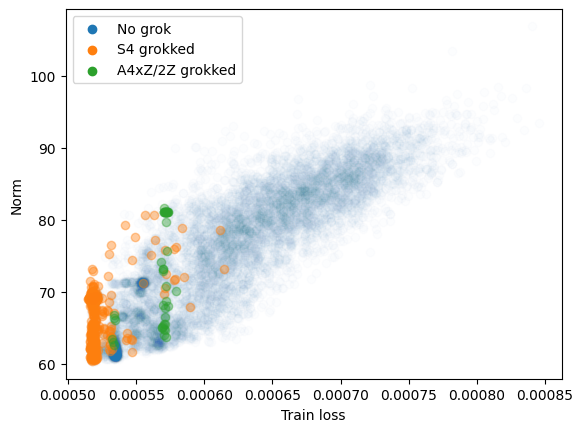

In [47]:
plt.scatter(train_loss[~grokked].detach().cpu(), norms[~grokked].detach().cpu(), alpha=0.01, label='No grok')
plt.scatter(train_loss[g0_grokked].detach().cpu(), norms[g0_grokked].detach().cpu(), label='S4 grokked', alpha=0.4)
plt.scatter(train_loss[g1_grokked].detach().cpu(), norms[g1_grokked].detach().cpu(), label='A4xZ/2Z grokked', alpha=0.4)
leg = plt.legend()
for lh in leg.legend_handles:
    lh.set_alpha(1)
plt.xlabel('Train loss')
plt.ylabel('Norm')
plt.show()

In [48]:
intersect_size = len(data.train_data) / data.N**2
c = np.array([
    [(g0_acc - intersect_size) / (1 - intersect_size), (g1_acc - intersect_size) / (1 - intersect_size), 0]
    for g0_acc, g1_acc in zip(loss_dict['G0_acc'], loss_dict['G1_acc'])
])
c = np.clip(c, 0, 1)

### LLC

In [49]:
llc_params = {
    'eps': 8e-4,
    'beta': 1e3,
    'gamma': 1.,
    'chains': 5,
    'cbatch_size': 5,
    'replacement': False,
    'behavioral': False,
    'epochs': 3000,
    # 'epochs': 10,
}

In [51]:
g0_llc, g0_trace = get_llc(g0_models, data, **llc_params)
g1_llc, g1_trace = get_llc(g1_models, data, **llc_params)
none_llc, none_trace = get_llc(none_models[:500], data, **llc_params)

SGLD:   0%|          | 0/3000 [00:00<?, ?it/s]

SGLD:   0%|          | 0/3000 [00:00<?, ?it/s]

SGLD:   0%|          | 0/3000 [00:00<?, ?it/s]

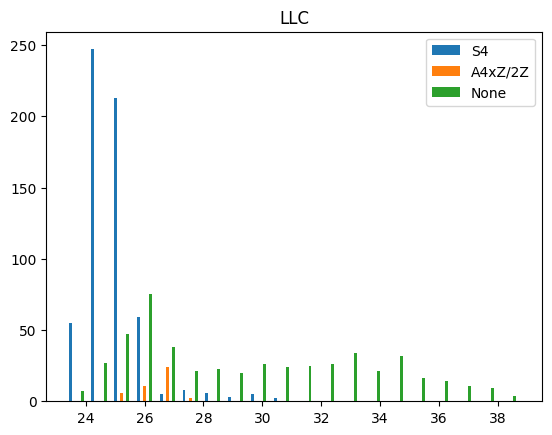

In [57]:
plt.hist([a.detach().cpu().numpy() for a in [g0_llc, g1_llc, none_llc]], bins=20, histtype='bar', label=['S4', 'A4xZ/2Z', 'None'], width=0.1)
plt.title('LLC')
plt.legend()
plt.show()

In [53]:
norms[~grokked].shape 

torch.Size([9354])

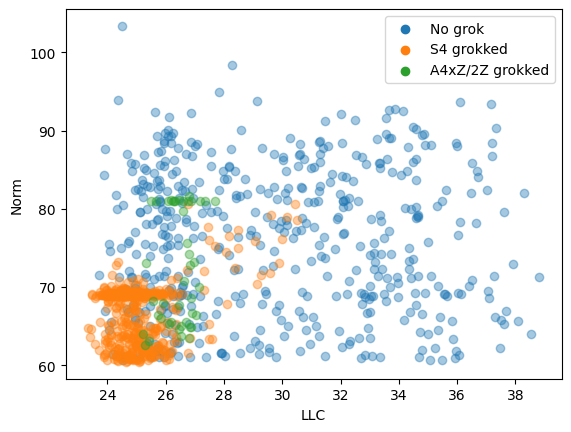

In [59]:
plt.scatter(none_llc.detach().cpu(), norms[~grokked][:500].detach().cpu(), alpha=0.4, label='No grok')
plt.scatter(g0_llc.detach().cpu(), norms[g0_grokked].detach().cpu(), label='S4 grokked', alpha=0.4)
plt.scatter(g1_llc.detach().cpu(), norms[g1_grokked].detach().cpu(), label='A4xZ/2Z grokked', alpha=0.4)
leg = plt.legend()
for lh in leg.legend_handles:
    lh.set_alpha(1)
plt.xlabel('LLC')
plt.ylabel('Norm')
plt.show()

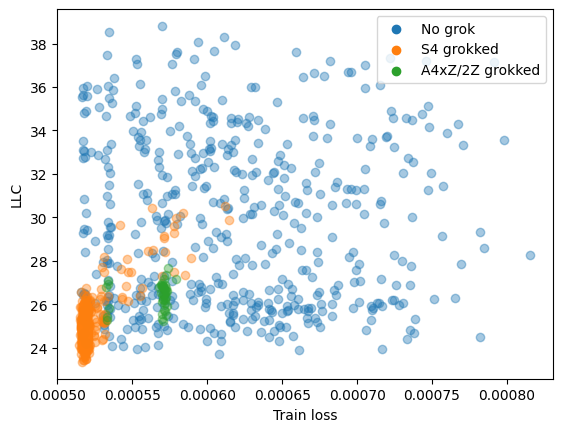

In [62]:
plt.scatter(train_loss[~grokked][:500].detach().cpu(), none_llc.detach().cpu(), alpha=0.4, label='No grok')
plt.scatter(train_loss[g0_grokked].detach().cpu(), g0_llc.detach().cpu(), label='S4 grokked', alpha=0.4)
plt.scatter(train_loss[g1_grokked].detach().cpu(), g1_llc.detach().cpu(), label='A4xZ/2Z grokked', alpha=0.4)
leg = plt.legend()
for lh in leg.legend_handles:
    lh.set_alpha(1)
plt.xlabel('Train loss')
plt.ylabel('LLC')
plt.show()

In [39]:
none_llc

tensor([37.7436, 30.2246, 31.3638, 24.8283, 26.9936, 26.6868, 33.0231, 29.3923,
        26.7915, 32.1474, 29.1077, 29.7145, 26.3947, 26.8998, 30.5455, 25.9352,
        30.5094, 35.8288, 24.3901, 33.7338, 24.2730, 33.5927, 34.7483, 27.6507,
        25.9691, 37.5047, 33.3037, 30.8781, 36.3799, 24.2400, 35.4319, 25.9159,
        33.1007, 34.9681, 35.1045, 31.1862, 24.8016, 26.9675, 33.4614, 25.9430,
        37.3856, 34.9138, 28.3284, 33.9492, 24.9591, 26.2995, 30.5487, 24.5400,
        25.4951, 27.3080, 26.1950, 27.8415, 35.0645, 28.5047, 26.9714, 32.3011,
        27.9944, 29.9088, 26.0048, 35.7658, 29.5153, 26.9648, 24.8905, 25.0875,
        31.5110, 28.8773, 26.2135, 31.7575, 29.8446, 26.0783, 26.0220, 37.3990,
        24.5295, 34.6216, 30.7982, 26.5391, 28.7863, 30.5868, 29.4972, 26.4468,
        31.3005, 24.6329, 37.3102, 31.6945, 32.2794, 28.0639, 30.9229, 35.0991,
        24.5763, 35.4760, 25.7322, 33.6456, 26.3293, 24.1042, 26.6148, 26.6724,
        28.4625, 25.9411, 25.8209, 32.12

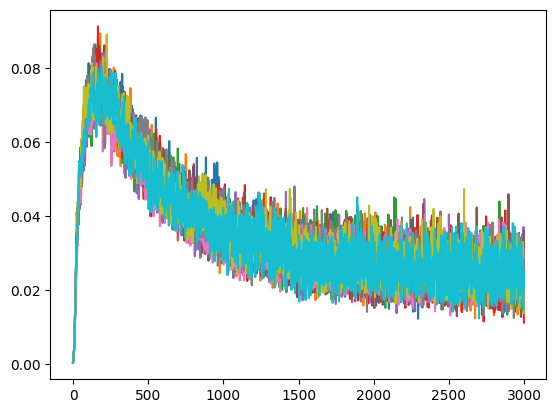

In [27]:
for i in range(10):
    plt.plot(g0_trace[i].detach().cpu())